## Tutorial of Patching Patching, Causal Scrubbing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/align-transformers/blob/main/tutorials/The%20capital%20of%20Spain%20is.ipynb)

In [1]:
__author__ = "Aryaman Arora and Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce some of the results in this [notebook](https://github.com/aryamanarora/nano-causal-interventions/blob/main/The%20capital%20of%20France%20is.ipynb) for path patching or causal scrubbing. This library could potentially support other kinds of interventions that were not originally supported by previous works.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [3]:
import sys
sys.path.append("..")

import pandas as pd
from models.utils import embed_to_distrib, top_vals, format_token
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import VanillaIntervention
from models.gpt_neox.modelings_alignable_gpt_neox import create_gpt_neox

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10

### Factual recall

In [4]:
import torch
sm = torch.nn.Softmax(dim=-1)
config, tokenizer, gpt = create_gpt_neox(name="EleutherAI/pythia-410m", cache_dir="~/.cache/huggingface")

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt"),
    tokenizer(source, return_tensors="pt")
]
print(base)
res = gpt(**inputs[0])
print(res.logits.shape)
# distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, sm(res.logits[0, -1]), n=10)
print()
print(source)
res = gpt(**inputs[1])
# distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, sm(res.logits[0, -1]), n=10)

loaded model
The capital of Spain is
torch.Size([1, 5, 50304])
_Madrid              0.15732870995998383
_the                 0.07052977383136749
_Se                  0.060051899403333664
_Gran                0.04910065233707428
_Zar                 0.04824012890458107
_Barcelona           0.03102891333401203
_in                  0.026770133525133133
_Vall                0.024149859324097633
_at                  0.022738635540008545
_Valencia            0.01717694289982319

The capital of Italy is
_P                   0.08371874690055847
_the                 0.07675594836473465
_Rome                0.06522124260663986
_Milan               0.06325820088386536
_called              0.027664678171277046
_Venice              0.02243625372648239
_in                  0.019679198041558266
_named               0.019434373825788498
_Pal                 0.01797953061759472
_not                 0.01769973710179329


### Patch Patching on Position-aligned Tokens
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [12]:
def simple_position_config(model_type, intervention_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=VanillaIntervention,
    )
    return alignable_config

def make_prompt(context, question, answer):
    return f"""Answer the question based on the context below. Keep your answer short.

Context: "{context}"

Question: "{question}"

Answer: "{' The' if answer.islower() else ''}"""

base = tokenizer(make_prompt("Tom hit John. He cried.", "Who cried?", "John"), return_tensors="pt")
sources = [tokenizer(make_prompt("Tom hit Bill. He cried.", "Who cried?", "Bill"), return_tensors="pt")]

In [14]:
from tqdm import tqdm

# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" John Bill")

data = []
for layer_i in tqdm(range(gpt.config.num_hidden_layers)):
    alignable_config = simple_position_config(type(gpt), "mlp_output", layer_i)
    alignable = AlignableModel(alignable_config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = sm(counterfactual_outputs.logits[0, -1])
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[token]),
                'layer': f"f{layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    alignable_config = simple_position_config(type(gpt), "attention_input", layer_i)
    alignable = AlignableModel(alignable_config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = sm(counterfactual_outputs.logits[0, -1])
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

  4%|▍         | 1/24 [01:17<29:31, 77.02s/it]


KeyboardInterrupt: 

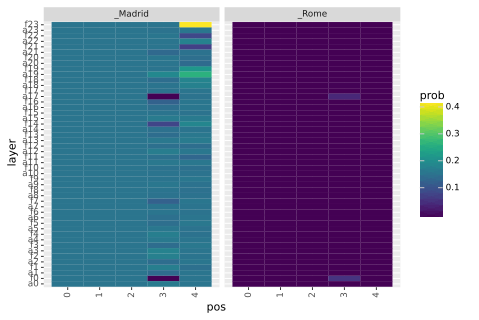

In [9]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(gpt.config.num_hidden_layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

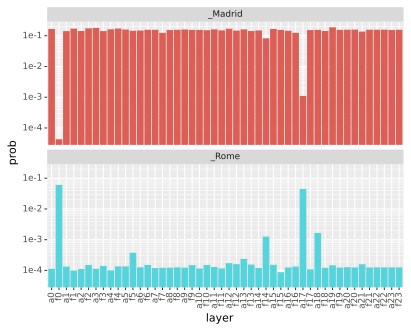

In [11]:
filtered = df
filtered = filtered[filtered['pos'] == 3]
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
print(g)